In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"
from models import*
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import joblib
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings("ignore")

### Import Model weights

In [7]:
mypath = '/local/home/lbiggio/comso_gen/weights/train_test/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
nnn=2
print(onlyfiles[nnn])

model = Generator(z_size=9,dec_type='upsampling',conv_dim=1,size_l=41,lr=1e-4,out_channels=1)
net = model.load_from_checkpoint(mypath+onlyfiles[nnn]).cuda()

upsampling_cosmo_gen_norm_1channel_new-epoch=1014-valid_loss=0.00.ckpt


### Import Data

In [3]:
trainx = np.load('epfldata/parameters_new.npy')
trainy = np.load('epfldata/vrms_map_new.npy')

scaling_y = np.load('scaler_y.npy')
scaling_x = joblib.load('scaler_x')

### Interface

In [8]:
def generate_maps(net,scaling_x,scaling_y,input_p, plot=True):
    """Generate velocity maps given input parameters.
    
    net: neural network object
    scaling_x: input scaler
    scaling_y: output scaling
    input_p: input parameters
    plt: plot if True
    
    Returns the velocity maps 
    """
    
    input_p = scaling_x.transform(np.reshape(input_p,(-1,len(input_p))))
    input_p = torch.Tensor(input_p).cuda()
    net.eval()
    
    with torch.no_grad():
        pred = net(input_p.unsqueeze(0)).cpu().numpy()
    
    if plot:
        plt.figure(figsize=(24, 6))
        plt.subplot(131)
        plt.imshow(pred[0,:,:].squeeze())
        plt.title('Prediction')
        plt.colorbar()
    
    return pred*scaling_y #### rotation

In [9]:
#for i in range(trainx.shape[1]):
#    plt.figure()
#    plt.hist(trainx[:,i])

### Example

input params:  [9.44922512e-01 8.26468232e-01 1.00161407e+00 3.10945081e+00
 7.90308638e-01 1.00000000e-04 4.60606795e-01 2.67345695e-01
 8.93001866e+01]


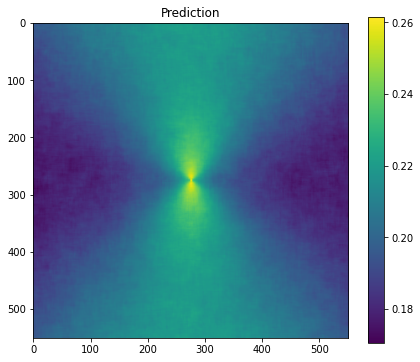

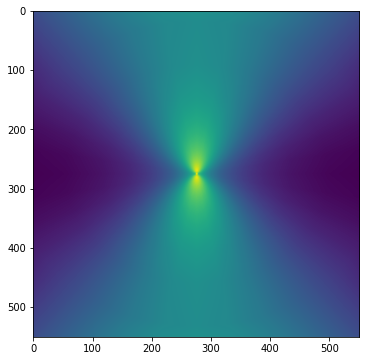

In [13]:
n = np.random.randint(5000)
print('input params: ',trainx[n])
output = generate_maps(net,scaling_x,scaling_y,trainx[n], plot=True)
plt.figure(figsize=(24, 6))
plt.imshow(trainy[n])

In [ ]:
span = np.linspace(-0.4,0.6,100)
inp = trainx[n]
for s in span:
    inp[-2] = s
    output = generate_maps(net,scaling_x,scaling_y,inp, plot=True)
    plt.title(str(s))